# Grads Project - Networks

### Import packages 

In [1]:
import networkx as nx
import pandas as pd
from pandas.io.common import is_url
import matplotlib.pyplot as plt

### Read in the ONS Input-output intermediate consumption table for 2018:

https://www.ons.gov.uk/file?uri=/economy/nationalaccounts/supplyandusetables/datasets/inputoutputsupplyandusetables/current/bb20detailedsutablepublication.xlsx

In [5]:
keep_rows = range(3, 110)
iosut_data = pd.read_excel(r"data/bb20detailedsutablepublication.xlsx",
                           sheet_name = "Table 2 - Int Con 2018",
                           skiprows = lambda x: x not in keep_rows,
                           na_values = '- ',
                           dtype = str)
iosut_data.head()

,Unnamed: 0,Unnamed: 1,A01,A02,A03,B05,B06 & B07,B08,B09,C101,...,Q87 & Q88,R90,R91,R92,R93,S94,S95,S96,T97,Unnamed: 107
0,NaN,Product,"Crop And Animal Production, Hunting And Relate...",Forestry And Logging,Fishing And Aquaculture,Mining Of Coal And Lignite,Extraction Of Crude Petroleum And Natural Gas ...,Other Mining And Quarrying,Mining Support Service Activities,Processing and preserving of meat and producti...,...,Residential Care & Social Work Activities,"Creative, Arts And Entertainment Activities","Libraries, Archives, Museums And Other Cultura...",Gambling And Betting Activities,Sports Activities And Amusement And Recreation...,Activities Of Membership Organisations,Repair Of Computers And Personal And Household...,Other Personal Service Activities,Activities Of Households As Employers Of Domes...,Total\nintermediate\ndemand
1,CPA_A01,"Products of agriculture, hunting and related s...",4488,4,0,0,0,8,0,6138,...,40,0,0,26,0,0,2,0,0,20259
2,CPA_A02,"Products of forestry, logging and related serv...",239,402,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,2753
3,CPA_A03,Fish and other fishing products; aquaculture p...,0,0,497,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2216
4,CPA_B05,Coal and lignite,0,0,0,16,0,5,0,0,...,0,0,0,0,0,22,0,0,0,1414


In [6]:
#remove uneeded columns and rows
iosut_data = iosut_data.drop('Unnamed: 1', axis=1)
iosut_data = iosut_data.drop('Unnamed: 107', axis=1)
iosut_data = iosut_data.drop(labels=0, axis=0)

# rename column
iosut_data = iosut_data.rename(columns = {'Unnamed: 0':'product'})

# remove spaces in column names and rows
iosut_data.columns = iosut_data.columns.str.replace(' ', '')
iosut_data['product'] = iosut_data['product'].str.replace(' ', '')

In [7]:
print(iosut_data.shape)
iosut_data.head(5)

(105, 106)


,product,A01,A02,A03,B05,B06&B07,B08,B09,C101,C102_3,...,Q86,Q87&Q88,R90,R91,R92,R93,S94,S95,S96,T97
1,CPA_A01,4488,4,0,0,0,8,0,6138,1514,...,21,40,0,0,26,0,0,2,0,0
2,CPA_A02,239,402,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0
3,CPA_A03,0,0,497,0,0,0,0,0,1355,...,0,0,0,0,0,0,0,0,0,0
4,CPA_B05,0,0,0,16,0,5,0,0,0,...,7,0,0,0,0,0,22,0,0,0
5,CPA_B06&B07,0,0,0,0,804,14,0,0,0,...,2,0,0,1,0,4,0,69,0,0


#### Basic QA check to ensure that industry names and column names match up

In [8]:
# remove "CPA_"
iosut_data['product_stripped'] = iosut_data['product'].str[4:]

columns = iosut_data.columns.to_list()[1:-1] # remove 'product' and 'product_stripped'
values = iosut_data['product_stripped'].tolist()

column_set = set(columns)
values_set = set(values)

# Check which columns/values do not match
print("Columns not in values", column_set.difference(values_set))
print("Values not in columns", values_set.difference(column_set))

Columns not in values {'C241T243', 'H493T495', 'C1101T1106&C12'}
Values not in columns {'H493_5', 'C11.01-6&C12', 'C241_3'}


In [9]:
# change col names that don't match
iosut_data.rename(columns={'C1101T1106&C12':'C11.01-6&C12'}, inplace=True)
iosut_data.rename(columns={'C241T243':'C241_3'}, inplace=True)
iosut_data.rename(columns={'H493T495':'H493_5'}, inplace=True)

In [11]:
# Create a lookup for SIC codes to industry names
sic_lookup = pd.read_csv(r"data/sic2007summaryofstructurtcm6.csv", 
                                usecols=[0,1],
                                encoding = "unicode_escape"
                               )

sic_lookup.columns = ['section', 'industry']
sic_lookup = sic_lookup.dropna().reset_index(drop = True)
sic_lookup

,section,industry
0,A,"AGRICULTURE, FORESTRY AND FISHING"
1,B,MINING AND QUARRYING
2,C,MANUFACTURING
3,D,"ELECTRICITY, GAS, STEAM AND AIR CONDITIONING S..."
4,E,"WATER SUPPLY; SEWERAGE, WASTE MANAGEMENT AND R..."
5,F,CONSTRUCTION
6,G,WHOLESALE AND RETAIL TRADE; REPAIR OF MOTOR VE...
7,H,TRANSPORTATION AND STORAGE
8,I,ACCOMMODATION AND FOOD SERVICE ACTIVITIES
9,J,INFORMATION AND COMMUNICATION


In [12]:
# convert wide table to long table
iosut_long = pd.melt(iosut_data, 
                     id_vars='product_stripped', 
                     value_vars=iosut_data.columns.to_list()[1:-1]).dropna()

# pull sic code from variables
iosut_long['product_stripped'] = iosut_long['product_stripped'].str[0]
iosut_long['industry'] = iosut_long['variable'].str[0]

In [13]:
# clean value string and convert to numeric
iosut_long['value'] = iosut_long['value'].str.replace(' ', '').astype(int)

#remove "loops" - these are within section transactions
iosut_long = iosut_long[iosut_long['product_stripped'] != iosut_long['industry']]
#remove null transactions
iosut_long = iosut_long[iosut_long['value'] != 0]

In [14]:
# groupby product and industry and sum
iosut_section_edges = iosut_long.groupby(['product_stripped', 'industry']).sum().reset_index()

In [15]:
iosut_section_edges.head()

,product_stripped,industry,value
0,A,B,8
1,A,C,17954
2,A,D,947
3,A,E,3
4,A,G,130


In [16]:
# Output processed data
iosut_section_edges.to_csv('data/iosut_section_edges.csv')

## Answering the analytical questions using the graph object

In [27]:
G = nx.from_pandas_edgelist(
    iosut_section_edges, target='industry', source='product_stripped', 
    edge_attr = 'value',       # this adds weighting to the edges based on transaction values
    create_using = nx.DiGraph  # this gives the network directionality
)

iosut_section_edges

,product_stripped,industry,value
0,A,B,8
1,A,C,17954
2,A,D,947
3,A,E,3
4,A,G,130
...,...,...,...
297,S,N,139
298,S,O,1769
299,S,P,300
300,S,Q,1360


#### Calculate metrics such as in- and out-degree

In [18]:
import pandas as pd
in_degrees = [G.in_degree(node) for node in G.nodes]
out_degrees = [G.out_degree(node) for node in G.nodes]
in_values = [G.in_degree(node, weight = 'value') for node in G.nodes]
out_values = [G.out_degree(node, weight= 'value') for node in G.nodes]

degrees_df = pd.DataFrame(
    data = {
        'node': G.nodes,
        'in_degree': in_degrees,
        'out_degree': out_degrees,
        'in_value': in_values,
        'out_value': out_values
    }
)

degrees_df

,node,in_degree,out_degree,in_value,out_value
0,A,13,11,14955,19598
1,B,14,14,13662,40780
2,C,17,18,121742,291884
3,D,13,18,30975,30352
4,E,17,18,11635,15639
5,G,15,15,149071,6427
6,I,16,18,44254,22797
7,K,18,18,114848,94077
8,L,16,16,63642,45429
9,Q,18,8,79881,1089


#### Which sectors have the highest number of other sectors they are supplying?

In [19]:
highest_number_supplying = max(degrees_df['out_degree'])
print(f"Highest number of sectors supplied is {highest_number_supplying}.")

degrees_df[degrees_df['out_degree']==highest_number_supplying]

Highest number of sectors supplied is 18.


,node,in_degree,out_degree,in_value,out_value
2,C,17,18,121742,291884
3,D,13,18,30975,30352
4,E,17,18,11635,15639
6,I,16,18,44254,22797
7,K,18,18,114848,94077
12,F,14,18,87236,48519
13,H,15,18,62868,93750
14,M,16,18,55303,144825
15,N,17,18,44934,116753
16,O,17,18,69906,15886


#### Which sector supplies the highest value of goods to other sectors?


In [20]:
max_out = max(degrees_df.out_value)
sector_out = degrees_df[degrees_df['out_value']==max_out].iloc[0,0]
print(f"Highest value of goods supplied by a sector is {max_out}, supplied by sector {sector_out}.")

Highest value of goods supplied by a sector is 291884, supplied by sector C.


#### Which sector buys the highest value of goods from other sectors?

In [21]:
max_in = max(degrees_df.in_value)
sector_in = degrees_df[degrees_df['in_value']==max_in].iloc[0,0]
print(f'Highest value of goods bought by a sector is {max_in}, bought by sector {sector_in}.')

Highest value of goods bought by a sector is 149071, bought by sector G.


#### Between which 2 sectors are the highest value of transactions? 

In [22]:
edge_values = {G.edges[edge]['value']: edge for edge in G.edges if edge[0]!=edge[1]}
highest_value = max(edge_values.keys())

print(f'Highest value of transactions is {highest_value} between sectors {edge_values[highest_value]}.')

Highest value of transactions is 55157 between sectors ('C', 'F').


#### Remove the sector-to-sector relationships of less than £1,000m and produce a visualisation of the network

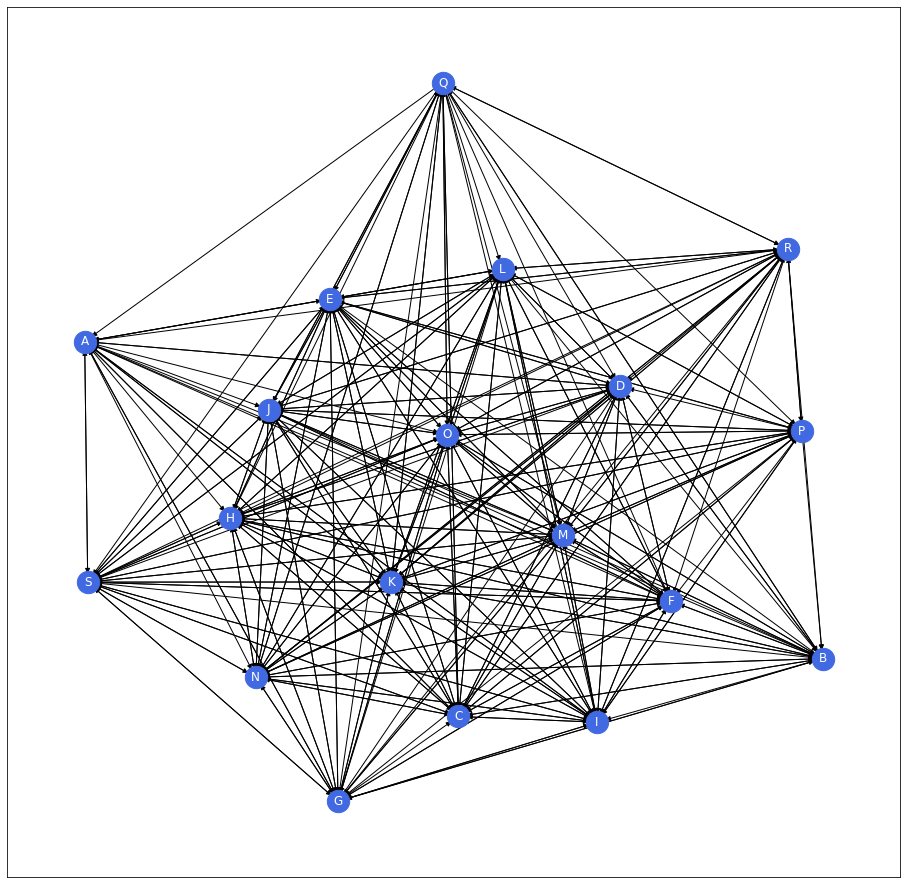

In [30]:
G_sub = nx.from_pandas_edgelist(
    iosut_section_edges, target='product_stripped', source='industry', 
    edge_attr = 'value', 
    create_using = nx.DiGraph
)

plt.figure(figsize=(16, 16))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=500, node_color = 'royalblue')
nx.draw_networkx_edges(G, pos, edgelist=G_sub.edges(), edge_color='black')
nx.draw_networkx_labels(G, pos, font_color = 'white')
plt.show()

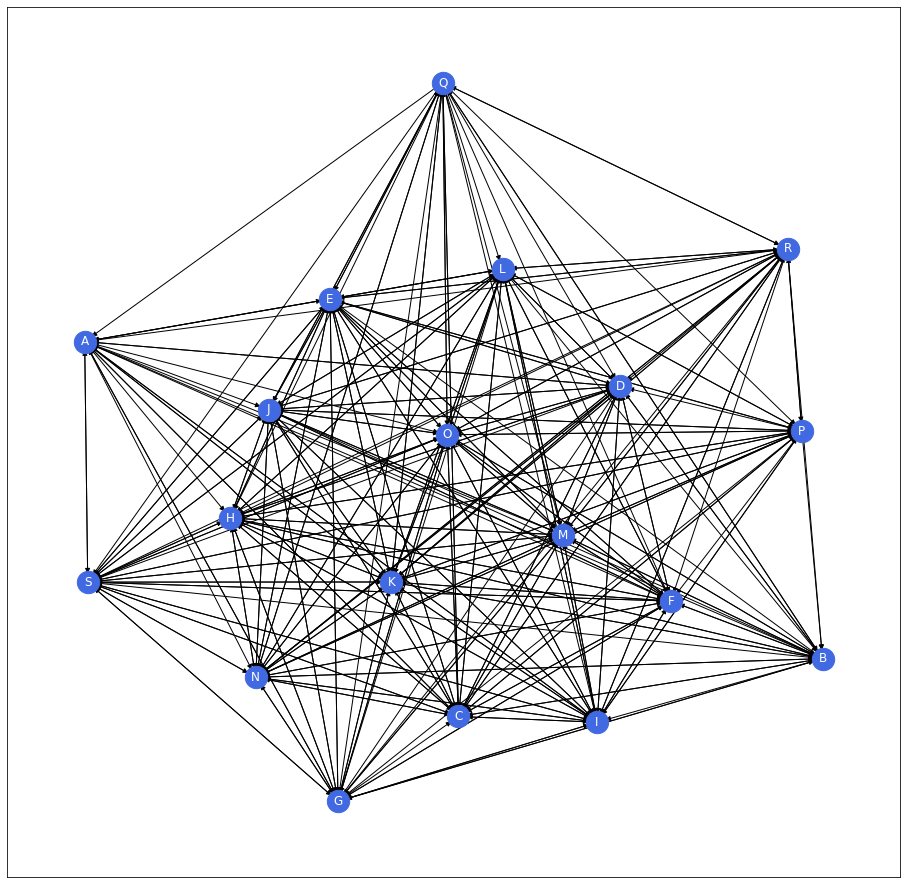

In [ ]:
selected_industries = 

G_sub = nx.from_pandas_edgelist(
    iosut_section_edges, target='product_stripped', source='industry', 
    edge_attr = 'value', 
    create_using = nx.DiGraph
)

plt.figure(figsize=(16, 16))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=500, node_color = 'royalblue')
nx.draw_networkx_edges(G, pos, edgelist=G_sub.edges(), edge_color='black')
nx.draw_networkx_labels(G, pos, font_color = 'white')
plt.show()

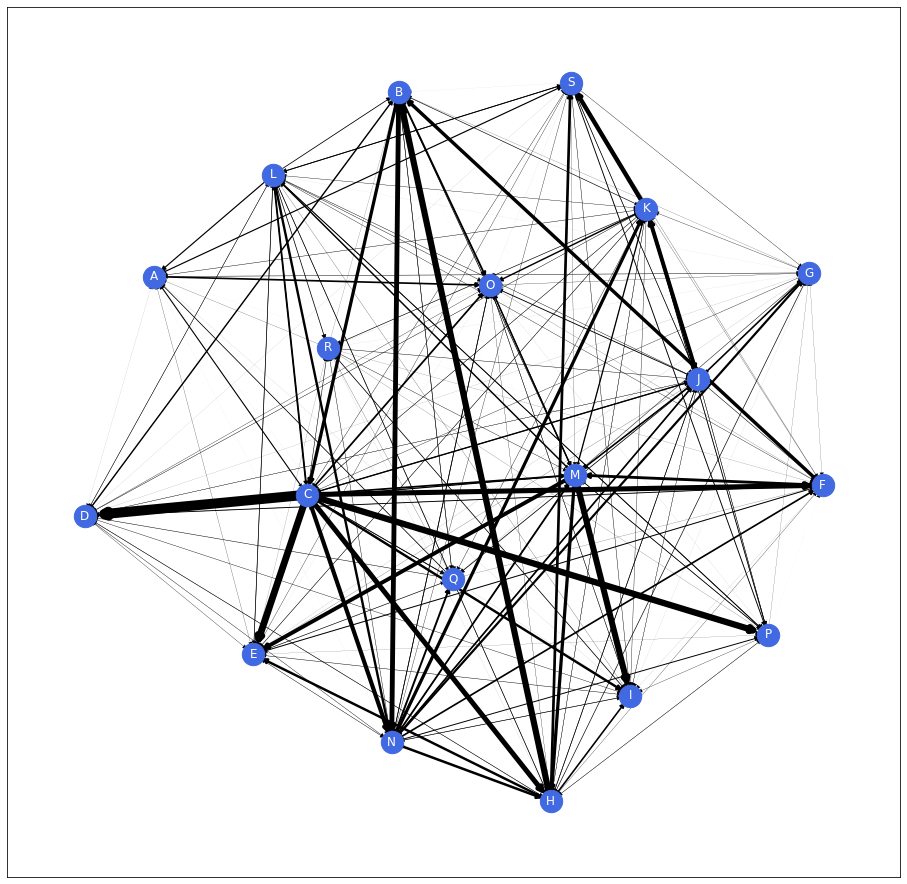

In [25]:
# with weights
edge_weights = [G.edges[edge]['value'] for edge in G.edges]
edge_widths = [weight / max(edge_weights) * 10 for weight in edge_weights]

plt.figure(figsize=(16, 16))
pos = nx.spring_layout(G_sub)
nx.draw_networkx_nodes(G_sub, pos, node_size=500, node_color = 'royalblue')
nx.draw_networkx_edges(G_sub, pos, edgelist=G_sub.edges(), edge_color='black', width = edge_widths)
nx.draw_networkx_labels(G_sub, pos, font_color = 'white')
plt.show()